# SHAP and LIME

***These examples are modified from notebook provided by Domino Data Lab, described in their 14 Aug 2019 webinar.***

<font color='darkgreen'>**As this notebook is lengthy, readers will find it much easier to navigate with [Jupyter Nbextensions](https://github.com/ipython-contrib/jupyter_contrib_nbextensions) installed, and Table of Contents (2) selected:**</font>

**Highlights**

* For the k-nearest neighbors model, computing Shapley values is prohibitive, due to the $\frac{k'(k'-1)}{2}$ distances that must be computed for each permutation of features left out; instead cluster size-weighted k-means values are supplied to `shap.KernelExplainer()`.
* Examples are provided for XGBoost Shapley force plots that generate separate image files that can be inserted into documents.
* As XGBoost `.predict()` requires DMatrix inputs, a wrapper function is invoked when generating LIME plots.
* For XGBoost there are examples of how to export images (PNG files in this case)

**Next two lines are useful in the event of external code changes.**

In [1]:
%load_ext autoreload
%autoreload 2

## Import libraries

Import local plotting routines.
The `plotHelpers` module includes `dependencePlot()`, which is a version of `shap.dependence_plot()` modified to allow for particular index values of the data to be overplotted in highlighted form.

>**`dependencePlot()` *not implimented yet***

In [2]:
import sys
# sys.path.append('../../Mlib')
# import plotHelpers as ph

In [3]:
from timeit import default_timer as dtime
from time import time, asctime, gmtime
t0 = dtime()
import os  #needed to use Environment Variables in Domino
import lime  #LIME package
import lime.lime_tabular  #the type of LIIME analysis we’ll do

print("Python version: ", sys.version_info[:])
print("Un-versioned imports:\n")
print('sys', end="")
if 'timeit' in sys.modules:
    print(', timeit', end="")
if 'time' in sys.modules:
    print(', time', end="")
if 'lime' in sys.modules:
    print(', lime', end="")
# if '' in sys.modules:
#     print(', ', end="")

import pandas as pd  #for manipulating data
import numpy as np  #for manipulating data
import sklearn  #for building models
import xgboost as xgb  #for building models
import sklearn.ensemble  #for building models
from sklearn.model_selection import train_test_split  #for creating a hold-out sample
import shap  #SHAP package
from matplotlib import __version__ as mpVersion
import matplotlib.pyplot as plt  #for custom graphs at the end
import seaborn as sns  #for custom graphs at the end
print("\n")
if 'pandas' in sys.modules:
    print(f"pandas: {pd.__version__}", end="\t")
if 'numpy' in sys.modules:
    print(f"numpy: {np.__version__}", end="\t")
if 'sklearn' in sys.modules:
    print(f"sklearn: {sklearn.__version__}", end="\t")
if 'xgboost' in sys.modules:
    print(f"xgboost: {xgb.__version__}", end="\t")
if 'shap' in sys.modules:
    print(f"shap: {shap.__version__}", end="\t")
if 'matplotlib' in sys.modules:
    print(f"matplotlib: {mpVersion}", end="\t")
if 'seaborn' in sys.modules:
    print(f"seaborn: {sns.__version__}", end="\t")
# if '' in sys.modules:
#     print(f": {.__version__}", end="\t")

# %matplotlib inline

Python version:  (3, 7, 5, 'final', 0)
Un-versioned imports:

sys, timeit, time, lime

pandas: 0.24.2	numpy: 1.16.4	sklearn: 0.21.2	xgboost: 1.0.0-SNAPSHOT	shap: 0.32.1	matplotlib: 3.1.0	seaborn: 0.9.0	

### Set `KMP_DUPLICATE_LIB_OK="TRUE`

This environment variable must be set `True` to keep `xgboost.train()` from killing the Jupyter kernel.

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Load and Explore Boston Housing Data

We are trying to predict median value of owner-occupied homes in $1000s.
The data comes from sklearn, so we can get more details about the columns from there.

In [5]:
X,y = shap.datasets.boston()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
X.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

***Homes were cheap when at the time this dataset was created!***

In [7]:
pd.Series(y).head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
dtype: float64

In [8]:
print(sklearn.datasets.load_boston().DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## It's model time

Will apply
* xgboost
* random forest
* KNN

### XGBoost

In [9]:
# xgb_model = xgb.train({'objective':'reg:linear'}, xgb.DMatrix(X_train, label=y_train))
xgb_model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X_train, label=y_train), 100)

### Gradient boosted trees from scikit-learn

In [10]:
skXGB = sklearn.ensemble.GradientBoostingRegressor()
skXGB.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Random Forest

In [11]:
RF = sklearn.ensemble.RandomForestRegressor()
RF.fit(X_train, y_train)

/home/wilber/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### K Nearest Neighbors

In [12]:
knn = sklearn.neighbors.KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

## Shapley explainers

### XGBoost

In [13]:
explainerXGB = shap.TreeExplainer(xgb_model)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

### Gradient boosted trees, sklearn

In [14]:
explainerSKGBT = shap.TreeExplainer(skXGB)
shap_values_SKGBT_test = explainerSKGBT.shap_values(X_test)
shap_values_SKGBT_train = explainerSKGBT.shap_values(X_train)

### Random Forest

In [15]:
explainerRF = shap.TreeExplainer(RF)
shap_values_RF_test = explainerRF.shap_values(X_test)
shap_values_RF_train = explainerRF.shap_values(X_train)

### KNN

* Processing is way too slow for KNN, unless steps are taken to summarize the data
* Here the strategy is to us k-Means

Rather than use the whole training set to estimate expected values, we summarize with a set of weighted kmeans, each weighted by the number of points they represent.
Running without the kmeans took 1 hr 6 mins 7 sec. 
Running with the kmeans took 2 min 47 sec.
Boston Housing is a very small dataset.
Running SHAP on models that require Kernel method and have a good amount of data becomes prohibitive.

#### Get them k-Means-summarized training datums

In [16]:
help(shap.kmeans)

Help on function kmeans in module shap.explainers.kernel:

kmeans(X, k, round_values=True)
    Summarize a dataset with k mean samples weighted by the number of data points they
    each represent.
    
    Parameters
    ----------
    X : numpy.array or pandas.DataFrame
        Matrix of data samples to summarize (# samples x # features)
    
    k : int
        Number of means to use for approximation.
    
    round_values : bool
        For all i, round the ith dimension of each mean sample to match the nearest value
        from X[:,i]. This ensures discrete features always get a valid value.
    
    Returns
    -------
    DenseData object.



In [17]:
X_train_summary = shap.kmeans(X_train, 10)

#### Extract Shapley values using the summarized training datums

Step takes ~4 mins.

In [18]:
# using kmeans
t0 = dtime()
explainerKNN = shap.KernelExplainer(knn.predict, X_train_summary)
shap_values_KNN_train = explainerKNN.shap_values(X_train)
shap_values_KNN_test = explainerKNN.shap_values(X_test)
t1 = dtime()
Δt=t1 - t0
print(f"Δt: {int(Δt//60): 2d}m, {Δt % 60.0: 4.1f}s")

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \



Δt:  3m,  49.8s


/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


## Get the SHAP values into dataframes so we can use them later on

### XGBoost

In [19]:
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

### Gradient boosted trees, sklearn

In [20]:
df_shap_SKGBT_test = pd.DataFrame(shap_values_SKGBT_test, columns=X_test.columns.values)
df_shap_SKGBT_train = pd.DataFrame(shap_values_SKGBT_train, columns=X_train.columns.values)

### Random Forest

In [21]:
df_shap_RF_test = pd.DataFrame(shap_values_RF_test, columns=X_test.columns.values)
df_shap_RF_train = pd.DataFrame(shap_values_RF_train, columns=X_train.columns.values)

### KNN

In [22]:
df_shap_KNN_test = pd.DataFrame(shap_values_KNN_test, columns=X_test.columns.values)
df_shap_KNN_train = pd.DataFrame(shap_values_KNN_train, columns=X_train.columns.values)

## LIME explainers

* If a feature has 10 or fewer unique values, treat as if it is categorical

In [23]:
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x])) 
                                             for x in range(X_train.values.shape[1])]) <= 10).flatten()

* Lime has one explainer for all models

In [24]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns.values.tolist(), 
                                                   class_names=['price'], 
                                                   categorical_features=categorical_features, 
                                                   verbose=True, 
                                                   mode='regression')

## Local interpretability (explaining single instances)

* Below, `j` is an instance to examine &mdash; picked randomly here
* shap `force_plot`s are generated by JavaScript, but if you insert arguments `show=False, matplotlib=True` (single instances only), the plotting is handled by matplotlib; append `.savefig(<figname>)` to create plot files for use elsewhere. *This seems to have an added bonus of making better use of available horizontal space.*

In [25]:
np.random.seed(5)
j = np.random.randint(0, X_test.shape[0])

#### Initialize Javascript

* The `shap` package uses javascript for plots ...

In [26]:
shap.initjs()

### XGBoost

#### Shapley

In [27]:
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

In [28]:
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j-20], X_test.iloc[[j-20]])

##### Save a copies as a PNG files

Note that the `bbox_inches='tight'` argument to `.savefig()` is needed to prevent cropping of title.

In [29]:
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]],
                show=False, matplotlib=True).savefig('ForcePlotXGBj.png', bbox_inches='tight')

In [30]:
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j - 20], X_test.iloc[[j - 20]],
                show=False, matplotlib=True).savefig('ForcePlotXGBjm20.png', bbox_inches='tight')

#### LIME

* Out-of-the-box LIME cannot handle the requirement of XGBoost to use xgb.DMatrix() on the input data.
* The predict function is inconsistent with it ...

$\longrightarrow$ create a wrapper function to insert the data into a DMatrix

In [31]:
xgb_model.predict(xgb.DMatrix(X_test.iloc[[j]]))
feature_names = xgb.DMatrix(X_test.iloc[[j]])._feature_names

##### Wrapper function `wrappedPredict()`

The lime package's `explainer.explain_instance()` method wants the input to be an ndarray, but the `xgb_model.predict()` method wants a DMatrix. To fix this, supply a wrapper for `.predict()` that takes the regular ndarray and creates the DMatrix before the predict.

This function follows the wrappers described in [how to use lime with xgboost? #334](https://github.com/marcotcr/lime/issues/334).

In [32]:
def wrappedPredict(Xj):
    '''
    wrap xgboost predict function in order to make it lime-friendly
    xgb_model and feature_names are defined outside
    '''

    yDummy = np.array([ 1 for _ in range(Xj.shape[0]) ])
    XDMatrix = xgb.DMatrix(Xj, yDummy, feature_names=feature_names)

    return xgb_model.predict(XDMatrix)

In [33]:
expXGB = explainer.explain_instance(X_test.values[j], wrappedPredict, num_features=5)
expXGB.show_in_notebook(show_table=True)

Intercept 15.022952495133966
Prediction_local [12.19688482]
Right: 13.120221


In [34]:
expXGB = explainer.explain_instance(X_test.values[j - 20], wrappedPredict, num_features=5)
expXGB.show_in_notebook(show_table=True)

Intercept 14.951525694436258
Prediction_local [11.77946913]
Right: 13.3734255


##### Create bar plot as PNG file

**Important:**

* Each invocation of `.explain_instance()` makes calls to `np.random`; do not call again if you want the saved image file to look like the in-line example above
* Only shows center of figure above
* Unfortunately, `.as_pyplot_figure()` seems to use 'classic' matplotlib 'r' and 'g' colors, instead of the v2.0 colors '#1f77b4' and '#FF7F0E'.
  * To get around this, painfully, you can alter the result on the command line with ImageMagick:
```bash
convert LIMEbarplotXGB.png -fuzz 15% -fill "#1F77B4" -opaque "#FF0000" tmp.png
convert tmp.png  -fuzz 15% -fill "#FF7F0E" -opaque "#008000" LIMEbarplotXGBmatching.png
rm -f tmp.png
```

Below, this conversion is done in-line using '!'.

In [35]:
# expXGB = explainer.explain_instance(X_test.values[j - 20], wrappedPredict, num_features=5)
fig = expXGB.as_pyplot_figure()
fig.savefig('LIMEbarplotXGB.png', bbox_inches='tight')

In [54]:
!convert LIMEbarplotXGB.png -fuzz 15% -fill "#1F77B4" -opaque "#FF0000" tmp.png
!convert tmp.png  -fuzz 15% -fill "#FF7F0E" -opaque "#008000" LIMEbarplotXGBmatching.png
!rm -f tmp.png

### Gradient boosted trees, sklearn

#### Shapley

In [36]:
shap.force_plot(explainerSKGBT.expected_value, shap_values_SKGBT_test[j], X_test.iloc[[j]])

In [37]:
shap.force_plot(explainerSKGBT.expected_value, shap_values_SKGBT_test[j-20], X_test.iloc[[j-20]])

#### LIME

In [38]:
expSKGBT = explainer.explain_instance(X_test.values[j], skXGB.predict, num_features=5)
expSKGBT.show_in_notebook(show_table=True)

Intercept 25.685291021371466
Prediction_local [17.38518101]
Right: 18.574645443101865


### Random Forest

#### Shapley

In [39]:
shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], X_test.iloc[[j]])

In [40]:
shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j-20], X_test.iloc[[j-20]])

In [41]:
shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j-20], X_test.iloc[[j-20]])

#### LIME

In [42]:
exp = explainer.explain_instance(X_test.values[j], RF.predict, num_features=5)
exp.show_in_notebook(show_table=True)

Intercept 26.008354817707147
Prediction_local [18.99946593]
Right: 19.2


### KNN

#### Shapley

**Note:** for reasons that remain unclear, the expected value for KNN needs to be coerced from a scalar ndarray to a float to avoid a `TypeError: len() of unsized object`.

In [43]:
shap.force_plot(float(explainerKNN.expected_value), shap_values_KNN_test[j], X_test.iloc[[j]])

In [44]:
shap.force_plot(float(explainerKNN.expected_value), shap_values_KNN_test[j-20], X_test.iloc[[j-20]])

#### LIME

In [45]:
exp = explainer.explain_instance(X_test.values[j], knn.predict, num_features=5)
exp.show_in_notebook(show_table=True)

Intercept 20.484382516129855
Prediction_local [23.76217053]
Right: 22.339999999999996


## Explaining the global model

### Feature importance using Shapley values

#### As bar plot

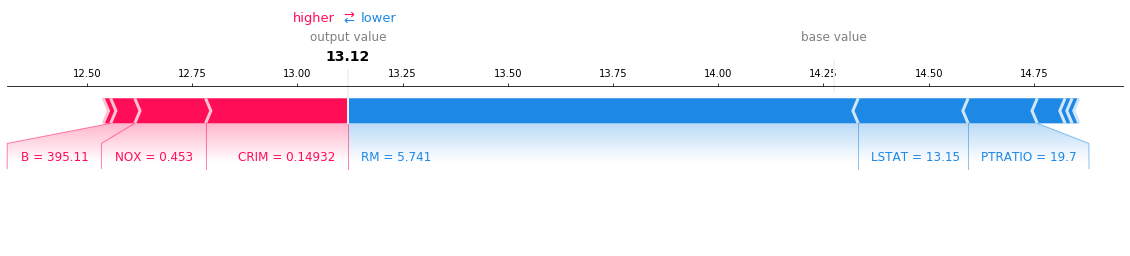

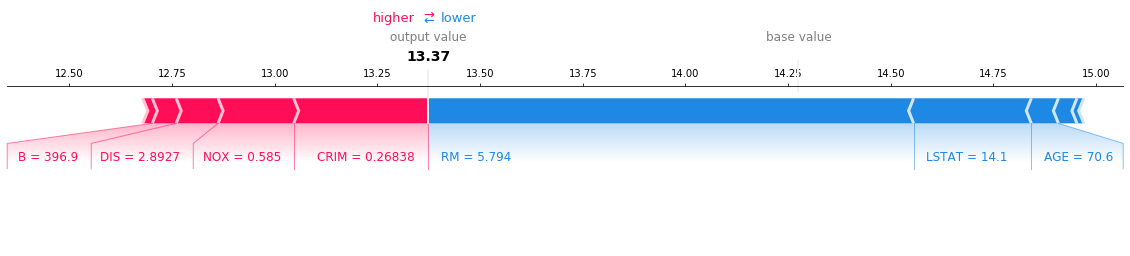

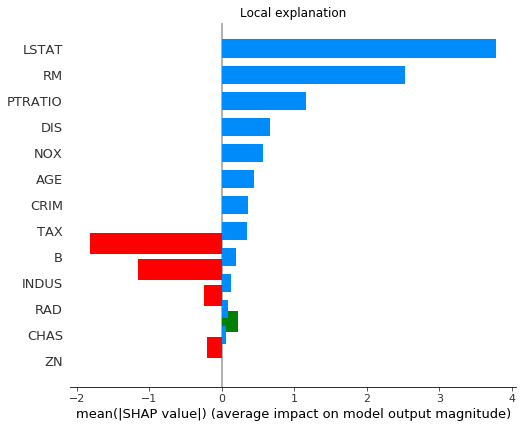

In [46]:
shap.summary_plot(shap_values_SKGBT_train, X_train, plot_type="bar")

#### Impact for each instance, for each feature

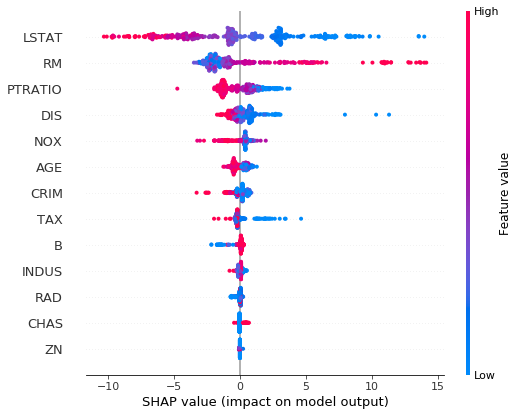

In [47]:
shap.summary_plot(shap_values_SKGBT_train, X_train)

### Variable influence / Dependency plots

#### Default

* scatter plots showing the Shapley value vs. the selected feature value
* the `interaction_index` (default: 'auto') is used to pick the feature determining the color (and hence the colorbar) for the point.
* if `interaction_index='auto'`, `shap_values_<model>_train` is used to determine that which interacts most with the specified feature.

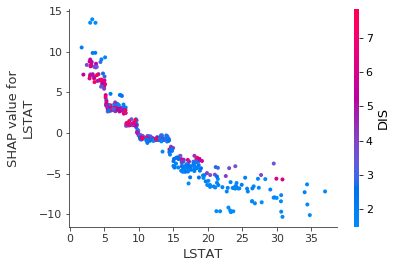

In [48]:
impColumns = df_shap_SKGBT_train.abs().mean().sort_values(ascending=False).index.tolist()

figure, ax = plt.subplots(1, 1)
shp_plt = shap.dependence_plot("LSTAT", shap_values_SKGBT_train, X_train, ax=ax)

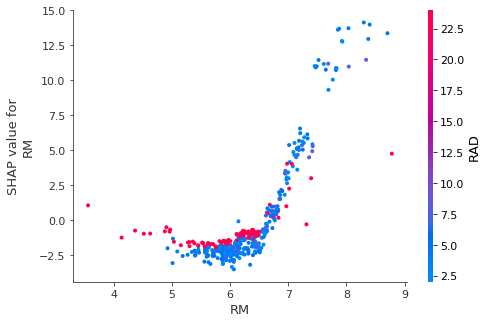

In [49]:
shp_plt = shap.dependence_plot("RM", shap_values_SKGBT_train, X_train)

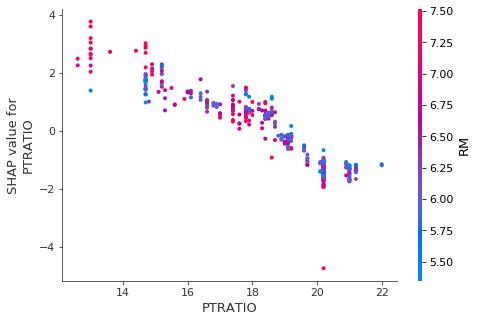

In [50]:
shp_plt = shap.dependence_plot("PTRATIO", shap_values_SKGBT_train, X_train)

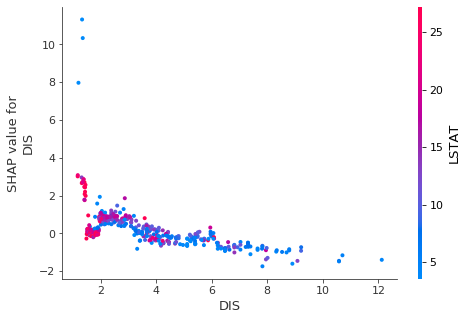

In [51]:
shp_plt = shap.dependence_plot("DIS", shap_values_SKGBT_train, X_train)

#### Feature highligting version

First, a helper function `dependencePlot()` is defined to replicate the plots, but allowing for the specific point to be highlighted.

In [52]:
# ph.dependencePlot("LSTAT", shap_values_SKGBT_train, X_train)